In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from urllib.parse import urlencode, quote_plus
# token = 'VYWwAEEAbtDwRwHeSHvRgn8dM0BmquNFZcD80b6t' # leahdzuckerman@gmail.com
# token = 'p23MxTBd9a6oELSfYOuRqOiyLR2E4v0WWeRyC1a7' # leah.zuckerman@gmail.com
# token = '0dCo6aRU7tZb2IRSFiGv1mFDEUUlX1SeeX0daqS6' # stephen.cholvat@gmail.com
token = 'XvcA0uWArSHzJVU1iuys6ew4ChZ56kYf6GcRuFZ6' # anna@nwlink.com
# token = 'twNua1LhNOoTxhPvt6dYcu8jA3uUH47kUjmVrgLc' # stephen.c.holvat@gmail.com
# token = 'LJNMK1LzWK7OQyR5W6hfWOcmwMUmwHEf7mLab55g' # leah.dzuckerman@gmail.com

In [3]:
'''
Get data for a large number of publications from ADS 'search' endpoint
 - Only 2000 results can be returned at once, so we need to loop to get more
 - Let's use max 1000 because we cant do more than 1000 requests/day to metrics endpoint, and pulling data from metrics (see below) has to be done individually
'''

fields = ['bibcode', 'author_count', 'aff', 'bibstem', 'citation_count', 'arxiv_class', 'year']
query = "database:astronomy year:2010-2025"
subject_to  = "database:astronomy arxiv_class:astro-ph*"
encoded_query = urlencode({'q': query, 'fq': subject_to, 'fl': ','.join(fields)})
data = pd.DataFrame(columns =fields)
N_tot = 999
count = 0
while count < N_tot:
    results = requests.get("https://api.adsabs.harvard.edu/v1/search/query?{encoded_query}&rows={rows}" \
                            "&start={start}".format(encoded_query=encoded_query,rows=5000,start=0), \
                            headers={'Authorization': 'Bearer ' + token})
    docs = results.json()['response']['docs'] # list of n = rows dictionaries
    for row in docs:
        if count < N_tot:
            bibcode = row['bibcode']
            author_count  = row['author_count'] if 'author_count' in row.keys() else None
            affiliation  = row['aff'] if 'aff' in row.keys() else None
            bibstem  = row['bibstem'] if 'bibstem' in row.keys() else None
            arxiv_class  = row['arxiv_class'] if 'arxiv_class' in row.keys() else None
            citation_count  = row['citation_count'] if 'citation_count' in row.keys() else None
            year  = row['year'] if 'year' in row.keys() else None
            data.loc[len(data)] = {'bibcode':bibcode, 'author_count':author_count, 'aff':affiliation, 'bibstem':bibstem, 'citation_count':citation_count, 'arxiv_class': arxiv_class, 'year': year}
            count += 1

print('Total records returned:', count)
print('Total requests remaining:', results.headers['X-RateLimit-Remaining'])
data.to_csv('../ads_data.csv', index=False)
display(data)

Total records returned: 999
Total requests remaining: 4999


,bibcode,author_count,aff,bibstem,citation_count,arxiv_class,year
0,2021arXiv210508081T,2,"[-, -]","[arXiv, arXiv2105]",5,"[astro-ph.EP, astro-ph.IM, physics.pop-ph]",2021
1,2020A&A...641A...6P,182,"[-, Institut d'Astrophysique Spatiale, CNRS, U...","[A&A, A&A...641]",14585,[astro-ph.CO],2020
2,2024ApJ...962L..15J,2,"[Southwest Research Institute, Boulder, CO 803...","[ApJL, ApJL..962]",5,[astro-ph.SR],2024
3,2016A&A...594A..13P,262,"[-, School of Physics and Astronomy, Cardiff U...","[A&A, A&A...594]",12509,[astro-ph.CO],2016
4,2013A&A...558A..33A,45,"[-, Max-Planck-Institut für Astronomie, Königs...","[A&A, A&A...558]",10922,[astro-ph.IM],2013
...,...,...,...,...,...,...,...
994,2022ApJ...927..192Y,14,"[Department of Physics and Astronomy, Texas A&...","[ApJ, ApJ...927]",133,"[astro-ph.GA, astro-ph.HE, astro-ph.IM]",2022
995,2022A&A...659A.191E,48,"[European Southern Observatory, Karl-Schwarzsc...","[A&A, A&A...659]",168,"[astro-ph.GA, astro-ph.IM]",2022
996,2022ApJS..261....2K,35,"[Eureka Scientific, 2452 Delmer Street, Suite ...","[ApJS, ApJS..261]",79,"[astro-ph.GA, astro-ph.HE]",2022
997,2024A&A...682L...3P,283,"[Max-Planck-Institut für Radioastronomie, Auf ...","[A&A, A&A...682]",15,"[astro-ph.HE, astro-ph.GA]",2024


In [4]:
'''
Add features pulled from ADS 'metrics' endpoint for each puplication (using stored bibcodes)
    - 'read_count' and 'download_count'
'''

data = pd.read_csv('../ads_data.csv')
try: # often we need to restart because connection times out
    print(f'Current length of temp: {len(temp["bibcode"])}')
except Exception:
    temp = {'bibcode':[], 'read_count':[], 'download_count':[]}
for i in range(len(data)):
    bibcode = data['bibcode'][i]
    if bibcode not in temp['bibcode']: # often we need to restart because connection times out
        result = requests.get("https://api.adsabs.harvard.edu/v1/metrics/{bibcode}".format(bibcode=bibcode), \
                            headers={'Authorization': 'Bearer ' + token})
        requests_left = result.headers.get("X-RateLimit-Remaining")
        metrics = result.json()['basic stats']
        print(f'Iteration {i}, total requests remaining {requests_left}, len(temp(bibcode)) {len(temp["bibcode"])} len(temp(read_code)) {len(temp["read_count"])} len(temp(read_code)) {len(temp["read_count"])}', end='\r')
        temp['bibcode'].append(bibcode)
        temp['read_count'].append(metrics['total number of reads'])
        temp['download_count'].append(metrics['total number of downloads'])
        if requests_left == '0':
            print(f'\nNo requests left, breaking')
            break

data['read_count'] = temp['read_count']
data['download_count'] = temp['download_count']

data.to_csv('../ads_data.csv', index=False)
display(data)


,bibcode,author_count,aff,bibstem,citation_count,arxiv_class,year,read_count,download_count
0,2021arXiv210508081T,2,"['-', '-']","['arXiv', 'arXiv2105']",5,"['astro-ph.EP', 'astro-ph.IM', 'physics.pop-ph']",2021,76921,3293
1,2020A&A...641A...6P,182,"['-', ""Institut d'Astrophysique Spatiale, CNRS...","['A&A', 'A&A...641']",14585,['astro-ph.CO'],2020,29322,9924
2,2024ApJ...962L..15J,2,"['Southwest Research Institute, Boulder, CO 80...","['ApJL', 'ApJL..962']",5,['astro-ph.SR'],2024,10261,169
3,2016A&A...594A..13P,262,"['-', 'School of Physics and Astronomy, Cardif...","['A&A', 'A&A...594']",12509,['astro-ph.CO'],2016,32802,9618
4,2013A&A...558A..33A,45,"['-', 'Max-Planck-Institut für Astronomie, Kön...","['A&A', 'A&A...558']",10922,['astro-ph.IM'],2013,14898,3091
...,...,...,...,...,...,...,...,...,...
994,2022ApJ...927..192Y,14,"['Department of Physics and Astronomy, Texas A...","['ApJ', 'ApJ...927']",133,"['astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM']",2022,1942,1072
995,2022A&A...659A.191E,48,"['European Southern Observatory, Karl-Schwarzs...","['A&A', 'A&A...659']",168,"['astro-ph.GA', 'astro-ph.IM']",2022,2188,1164
996,2022ApJS..261....2K,35,"['Eureka Scientific, 2452 Delmer Street, Suite...","['ApJS', 'ApJS..261']",79,"['astro-ph.GA', 'astro-ph.HE']",2022,1610,773
997,2024A&A...682L...3P,283,"['Max-Planck-Institut für Radioastronomie, Auf...","['A&A', 'A&A...682']",15,"['astro-ph.HE', 'astro-ph.GA']",2024,757,349


Numerical Columns: Index(['author_count', 'citation_count', 'year', 'read_count',
       'download_count'],
      dtype='object')


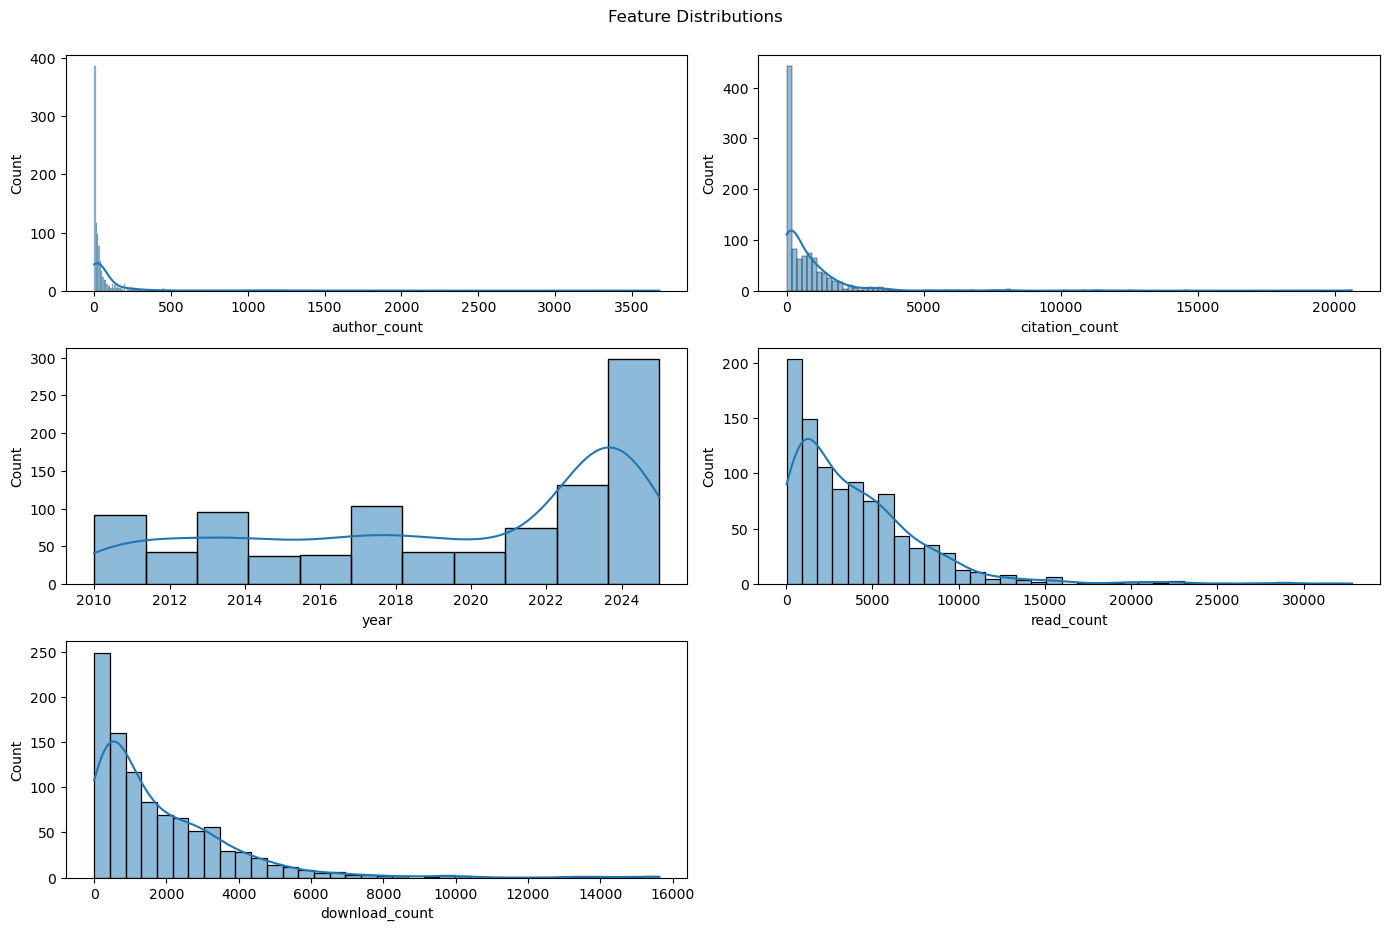

In [20]:
'''
Explore Feature Distributions
'''

data = pd.read_csv('../ads_data.csv')
numerical_cols = data.select_dtypes(include=[np.float64, np.int64]).columns
print('Numerical Columns:', numerical_cols)
fig = plt.figure(figsize=(14, len(numerical_cols)*3))
plt.suptitle('Feature Distributions')
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

<AxesSubplot:title={'center':'Feature Correlations'}>

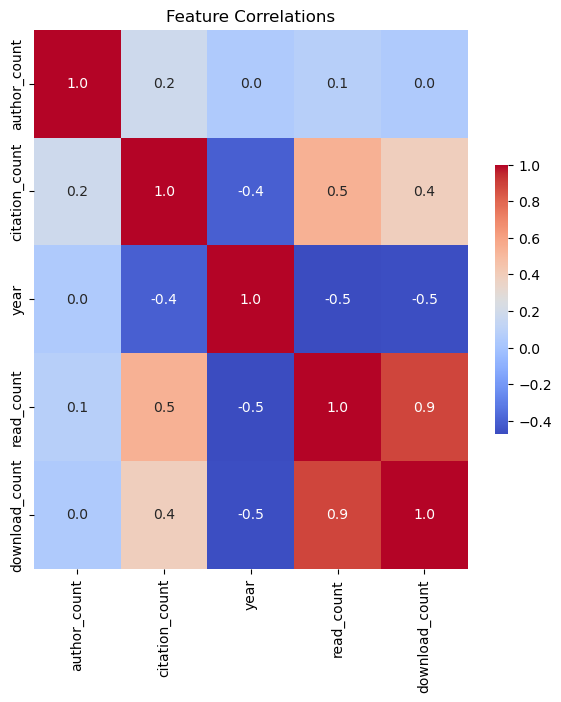

In [23]:
'''
Plot feature correlations
'''

data = pd.read_csv('../ads_data.csv')
corr = data[numerical_cols].corr()
fig = plt.figure(figsize=(7, 7))
plt.title('Feature Correlations')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={"shrink": 0.5})

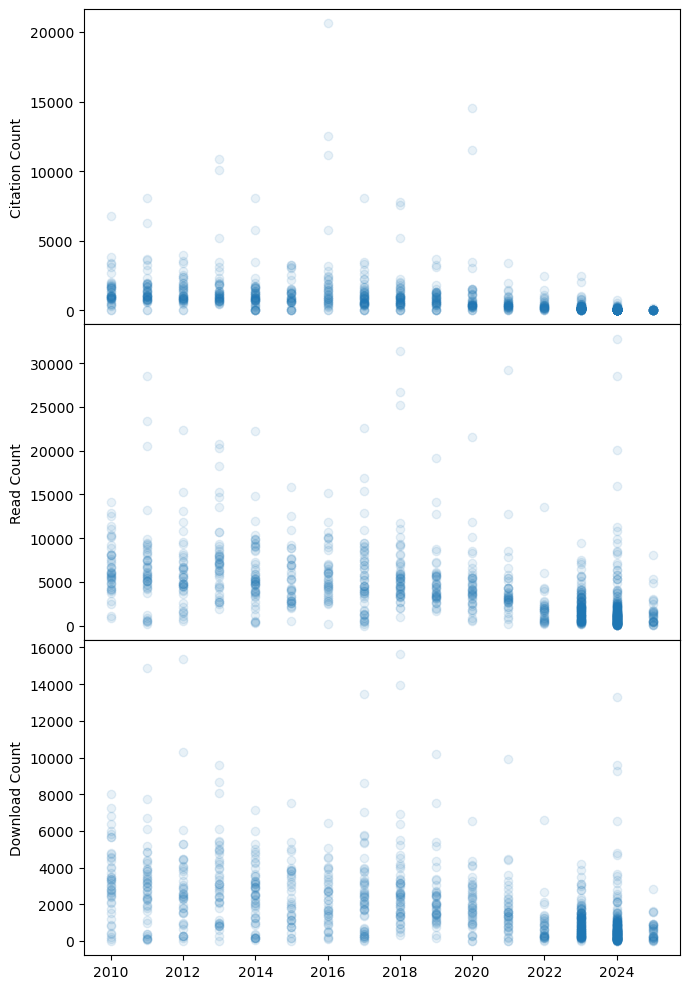

In [14]:
'''
Simple temporal analysis
'''

data = pd.read_csv('../ads_data.csv')
fig, axs = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
axs[0].scatter(data['year'], data['citation_count'], alpha=0.1, label='Citation Count')
axs[1].scatter(data['year'], data['read_count'], alpha=0.1,  label='Read Count')
axs[2].scatter(data['year'], data['download_count'], alpha=0.1, label='Download Count')
axs[0].set_ylabel('Citation Count')
axs[1].set_ylabel('Read Count')
axs[2].set_ylabel('Download Count')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [18]:
'''
Explore affiliations
'''

data = pd.read_csv('../ads_data.csv')
affs = []
for i in range(len(data)):
    print(data.iloc[i]['aff'])
    if i == 10:
        break
    # affiliations = data.iloc[i]['aff'].replace('[','').replace(']','').replace('\'','').split(', ')
    # affs = affs + affiliations
# affiliation_counts = pd.Series(affs).value_counts()
# print(affiliation_counts)

['-', '-']
['-', "Institut d'Astrophysique Spatiale, CNRS, Univ. Paris-Sud, Université Paris-Saclay, Bât. 121, 91405, Orsay Cedex, France", 'Département de Physique, École normale supérieure, PSL Research University, CNRS, 24 rue Lhomond, 75005, Paris, France; Institute Lorentz, Leiden University, PO Box 9506, Leiden, 2300 RA, The Netherlands; Institute of Theoretical Astrophysics, University of Oslo, Blindern, Oslo, Norway', 'Kavli Institute for Cosmology Cambridge, Madingley Road, Cambridge, CB3 0HA, UK; Astrophysics Group, Cavendish Laboratory, University of Cambridge, J J Thomson Avenue, Cambridge, CB3 0HE, UK', 'Université de Toulouse, UPS-OMP, IRAP, 31028, Toulouse Cedex 4, France', 'SISSA, Astrophysics Sector, Via Bonomea 265, 34136, Trieste, Italy', 'Department of Physics &amp; Astronomy, University of the Western Cape, Cape Town, 7535, South Africa; INAF - OAS Bologna, Istituto Nazionale di Astrofisica - Osservatorio di Astrofisica e Scienza dello Spazio di Bologna, Area della